# Stock Price Prediction using ramdom forest

In this notebook model is created using some realworld features and predictor varibales and using that trying to prediction with score above 70%.
For this we are using random forest algorith from scikit-learn library

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import numpy as np
from sklearn.ensemble import RandomForestClassifier

Using the Yahoo finance website 10 yr share data is collected and used.

# Stock Name - JP Morgan

In [3]:
ticker= "jpm"
data = yf.download(ticker, start="2011-10-12", end="2021-10-11")
print(data.tail())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-10-04  166.970001  170.440002  165.729996  166.949997  164.961197   
2021-10-05  167.210007  170.139999  166.669998  168.660004  167.655060   
2021-10-06  167.990005  169.100006  166.000000  169.020004  168.012909   
2021-10-07  171.199997  171.509995  169.539993  170.089996  169.076523   
2021-10-08  170.020004  171.339996  169.300003  170.220001  169.205750   

              Volume  
Date                  
2021-10-04  14120000  
2021-10-05  12292900  
2021-10-06   8692600  
2021-10-07  10195400  
2021-10-08   8188800  


# Feature constructions or predictor variables

# Stochastic Oscillator (%K)
A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. The sensitivity of the oscillator to market movements is reducible by adjusting that time period or by taking a moving average of the result. It is used to generate overbought and oversold trading signals, utilizing a 0–100 bounded range of values.

	  
%K=((C−L14)/(H14−L14))×100

where:
C = The most recent closing price
L14 = The lowest price traded of the 14 previous trading sessions
H14 = The highest price traded during the same
14-day period
%K = The current value of the stochastic indicator

In [4]:
# Stochastic Oscillator
h14= data['High'].rolling(14).max()
l14 = data['Low'].rolling(14).min()
data['%K'] = (data['Close'] - l14)*100/(h14 - l14)

# Relative Strength Index (RSI)
The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100. 

In [5]:
# Calculate RSI
delta = data['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
data['RSI'] = 100 - (100/(1 + rs))

# Moving Average (MA) & Moving Average Convergence Divergence (MACD)

In statistics, a moving average is a calculation used to analyze data points by creating a series of averages of different subsets of the full data set. In finance, a moving average (MA) is a stock indicator that is commonly used in technical analysis. The reason for calculating the moving average of a stock is to help smooth out the price data by creating a constantly updated average price.

Moving average convergence divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. The MACD is calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA.

Formula :
MACD = 12 Period EMA − 26 Period EMA

In [6]:
# Calculate the MACD signal
exp1 = data['Close'].ewm(span=12).mean()
exp2 = data['Close'].ewm(span=26).mean()
macd = exp1 - exp2
macd_signal = macd.ewm(span=9).mean()
data['MACD'] = macd_signal - macd

# Williams Percentage Range (%R)
Williams is a type of momentum indicator that moves between 0 and -100 and measures overbought and oversold levels. The Williams %R may be used to find entry and exit points in the market. The indicator is very similar to the Stochastic oscillator and is used in the same way. It was developed by Larry Williams and it compares a stock’s closing price to the high-low range over a specific period, typically 14 days or periods.

R= Highest High−Lowest Low / Highest High−Close
 

Highest High=Highest price in the lookback period, typically 14 days.
Close=Most recent closing price.
Lowest Low=Lowest price in the lookback period, typically 14 days.	

In [7]:
# Williams Percentage Range
data['%R'] = -100*(h14 - data['Close'])/(h14 - l14)

# Price Rate Of Change (ROC) Indicator
The Price Rate of Change (ROC) is a momentum-based technical indicator that measures the percentage change in price between the current price and the price a certain number of periods ago. The ROC indicator is plotted against zero, with the indicator moving upwards into positive territory if price changes are to the upside, and moving into negative territory if price changes are to the downside.

This indicator used to plot divergence.

In [8]:
# Price Rate of Change
days = 5
ct_n = data['Close'].shift(days)
data['PROC'] = (data['Close'] - ct_n)/ct_n

In [9]:
# Set class labels to classify
data['Return'] = data['Close'].pct_change(1).shift(-1)
data['class'] = np.where(data['Return'] > 0, 1, 0)

# Input & Output dataset
Using the dropna a panda library to remove the missing values as a data clean operation.

In [10]:
data.dropna(inplace=True)

# X is the input variable
X = data[['%K','RSI','%R','PROC','class','Return']]

# Y is the target or output variable
y = np.where(data['MACD'].shift(-1) > data['MACD'], 1, -1)

Checking the data srt lenth and splitting data into 75% training data and rest 25% as test data

In [11]:
dataset_length = data.shape[0]
split = int(dataset_length * 0.70)
split

1750

In [12]:
# Splitiing the X and y into train and test datasets
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Print the size of the train and test dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1750, 6) (751, 6)
(1750,) (751,)


# Training ML model using Random Forest

In [13]:
clf = RandomForestClassifier(random_state=5)

In [14]:
# Create the model on train dataset
model = clf.fit(X_train, y_train)

In [15]:
from sklearn.metrics import accuracy_score
print('Prediction : ', accuracy_score(y_test, model.predict(X_test), normalize=True))
print('Correct Prediction (%): ', accuracy_score(y_test, model.predict(X_test), normalize=True)*100.0)

Prediction :  0.8149134487350199
Correct Prediction (%):  81.49134487350199


# Verification / Data representation

In [16]:
# Report metrics (Classification)
from sklearn.metrics import classification_report
report = classification_report(y_test, model.predict(X_test))
print(report)

              precision    recall  f1-score   support

          -1       0.84      0.78      0.81       374
           1       0.79      0.85      0.82       377

    accuracy                           0.81       751
   macro avg       0.82      0.81      0.81       751
weighted avg       0.82      0.81      0.81       751



In [17]:
data['strategy'] = data.MACD.shift(-1) * model.predict(X)

Matplotlib is building the font cache; this may take a moment.


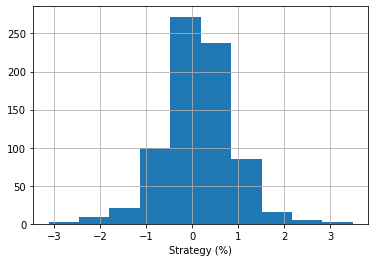

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
data.strategy[split:].hist()
plt.xlabel('Strategy (%)')
plt.show()

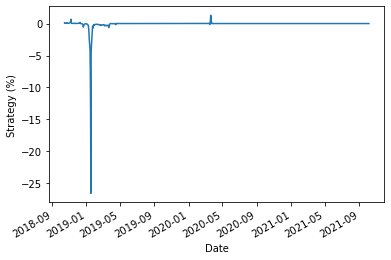

In [19]:
(data.strategy[split:]+1).cumprod().plot()
plt.ylabel('Strategy (%)')
plt.show()

# Note : 
To build various feature constructions or predictor variables, intevstopedia website is used as a refenc
* Stochastic Oscillator - https://www.investopedia.com/terms/s/stochasticoscillator.asp
* Relative Strength Index - https://www.investopedia.com/terms/r/rsi.asp
* Moving Average Convergence Divergence - https://www.investopedia.com/terms/m/macd.asp
* Williams Percentage Range - https://www.investopedia.com/terms/w/williamsr.asp
* Price Rate Of Change - https://www.investopedia.com/terms/p/pricerateofchange.asp

# Stock Name - Berkshire Hathaway (Class A)

In [20]:
ticker= "BRK-A"
data = yf.download(ticker, start="2011-10-12", end="2021-10-11")
print(data.tail())

[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2021-10-04  415146.0  416804.0  411286.0  412540.0   412540.0      14
2021-10-05  413313.0  420959.0  411659.0  418539.0   418539.0       9
2021-10-06  416406.0  421900.0  413662.0  421900.0   421900.0      11
2021-10-07  424999.0  428655.0  423516.0  425431.0   425431.0      12
2021-10-08  425643.0  428479.0  424000.0  427765.0   427765.0      13


In [21]:
# Stochastic Oscillator
h14= data['High'].rolling(14).max()
l14 = data['Low'].rolling(14).min()
data['%K'] = (data['Close'] - l14)*100/(h14 - l14)

# Calculate RSI
delta = data['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
data['RSI'] = 100 - (100/(1 + rs))

# Calculate the MACD signal
exp1 = data['Close'].ewm(span=12).mean()
exp2 = data['Close'].ewm(span=26).mean()
macd = exp1 - exp2
macd_signal = macd.ewm(span=9).mean()
data['MACD'] = macd_signal - macd

#Williams Percentage Range
data['%R'] = -100*(h14 - data['Close'])/(h14 - l14)

# Price Rate of Change
days = 5
ct_n = data['Close'].shift(days)
data['PROC'] = (data['Close'] - ct_n)/ct_n

# Set class labels to classify
data['Return'] = data['Close'].pct_change(1).shift(-1)
data['class'] = np.where(data['Return'] > 0, 1, 0)

In [22]:
data.dropna(inplace=True)

# X is the input variable
X = data[['%K','RSI','%R','PROC','class','Return']]

# Y is the target or output variable
y = np.where(data['MACD'].shift(-1) > data['MACD'], 1, -1)

dataset_length = data.shape[0]
split = int(dataset_length * 0.70)
split

# Splitiing the X and y into train and test datasets
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Print the size of the train and test dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1750, 6) (751, 6)
(1750,) (751,)


In [23]:
clf = RandomForestClassifier(random_state=5)

# Create the model on train dataset
model = clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
print('Prediction : ', accuracy_score(y_test, model.predict(X_test), normalize=True))
print('Correct Prediction (%): ', accuracy_score(y_test, model.predict(X_test), normalize=True)*100.0)

Prediction :  0.7736351531291611
Correct Prediction (%):  77.3635153129161


              precision    recall  f1-score   support

          -1       0.77      0.81      0.78       385
           1       0.78      0.74      0.76       366

    accuracy                           0.77       751
   macro avg       0.77      0.77      0.77       751
weighted avg       0.77      0.77      0.77       751



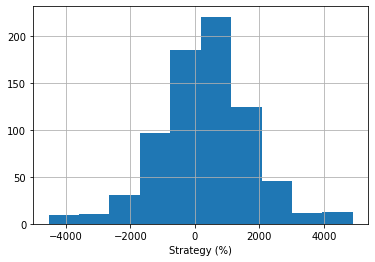

/Users/sushrutmujumdar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2740: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


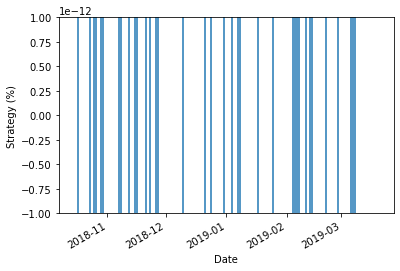

In [24]:
# Report metrics (Classification)
from sklearn.metrics import classification_report
report = classification_report(y_test, model.predict(X_test))
print(report)

data['strategy'] = data.MACD.shift(-1) * model.predict(X)

%matplotlib inline
import matplotlib.pyplot as plt
data.strategy[split:].hist()
plt.xlabel('Strategy (%)')
plt.show()

(data.strategy[split:]+1).cumprod().plot()
plt.ylabel('Strategy (%)')
plt.show()

# Stock Name - Morgan Stanley

In [25]:
ticker= "MS"
data = yf.download(ticker, start="2011-10-12", end="2021-10-11")
print(data.tail())

[*********************100%***********************]  1 of 1 completed
                  Open        High        Low       Close  Adj Close   Volume
Date                                                                         
2021-10-04   99.050003  100.510002  96.970001   97.150002  95.814735  9482100
2021-10-05   98.220001   99.730003  97.470001   99.199997  97.836555  8850300
2021-10-06   98.220001   99.459999  97.220001   99.099998  97.737930  6912700
2021-10-07  100.559998  100.919998  98.690002   98.800003  97.442055  7959600
2021-10-08   99.019997  100.690002  98.389999  100.040001  98.665016  5300300


In [26]:
# Stochastic Oscillator
h14= data['High'].rolling(14).max()
l14 = data['Low'].rolling(14).min()
data['%K'] = (data['Close'] - l14)*100/(h14 - l14)

# Calculate RSI
delta = data['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
data['RSI'] = 100 - (100/(1 + rs))

# Calculate the MACD signal
exp1 = data['Close'].ewm(span=12).mean()
exp2 = data['Close'].ewm(span=26).mean()
macd = exp1 - exp2
macd_signal = macd.ewm(span=9).mean()
data['MACD'] = macd_signal - macd

#Williams Percentage Range
data['%R'] = -100*(h14 - data['Close'])/(h14 - l14)

# Price Rate of Change
days = 5
ct_n = data['Close'].shift(days)
data['PROC'] = (data['Close'] - ct_n)/ct_n

# Set class labels to classify
data['Return'] = data['Close'].pct_change(1).shift(-1)
data['class'] = np.where(data['Return'] > 0, 1, 0)

In [27]:
data.dropna(inplace=True)

# X is the input variable
X = data[['%K','RSI','%R','PROC','class','Return']]

# Y is the target or output variable
y = np.where(data['MACD'].shift(-1) > data['MACD'], 1, -1)

dataset_length = data.shape[0]
split = int(dataset_length * 0.70)
split

# Splitiing the X and y into train and test datasets
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Print the size of the train and test dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1750, 6) (751, 6)
(1750,) (751,)


In [28]:
clf = RandomForestClassifier(random_state=5)

# Create the model on train dataset
model = clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
print('Prediction : ', accuracy_score(y_test, model.predict(X_test), normalize=True))
print('Correct Prediction (%): ', accuracy_score(y_test, model.predict(X_test), normalize=True)*100.0)

Prediction :  0.7989347536617842
Correct Prediction (%):  79.89347536617842


              precision    recall  f1-score   support

          -1       0.80      0.80      0.80       370
           1       0.80      0.80      0.80       381

    accuracy                           0.80       751
   macro avg       0.80      0.80      0.80       751
weighted avg       0.80      0.80      0.80       751



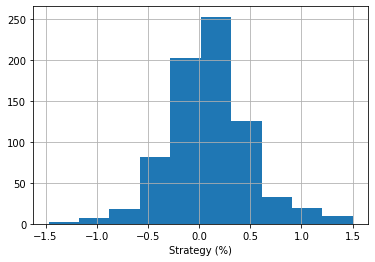

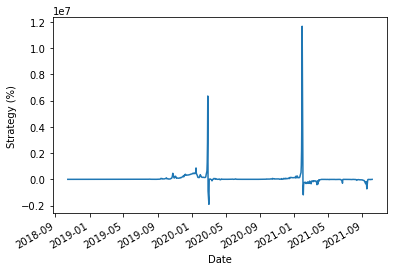

In [29]:
# Report metrics (Classification)
from sklearn.metrics import classification_report
report = classification_report(y_test, model.predict(X_test))
print(report)

data['strategy'] = data.MACD.shift(-1) * model.predict(X)

%matplotlib inline
import matplotlib.pyplot as plt
data.strategy[split:].hist()
plt.xlabel('Strategy (%)')
plt.show()

(data.strategy[split:]+1).cumprod().plot()
plt.ylabel('Strategy (%)')
plt.show()